# Import libraries

In [ ]:
import os
import tarfile
import urllib
import urllib.request
import pandas as pd
import numpy as np
from zlib import crc32
import joblib
from scipy.stats import randint

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats


import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

In [ ]:
os.chdir("/content/drive/My Drive/hands-on-ml")
%ls

datasets/  notebooks/


# Load the Data Set

In [ ]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = os.path.join(DOWNLOAD_ROOT, HOUSING_PATH+"/housing.tgz")

In [ ]:
def fetch_housing_data():
    os.makedirs(HOUSING_PATH, exist_ok=True)
    tgz_path = os.path.join(HOUSING_PATH, "housing.tgz")
    urllib.request.urlretrieve(HOUSING_URL, filename=tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=HOUSING_PATH)
    housing_tgz.close()


def load_housing_data():
    csv_path = os.path.join(HOUSING_PATH, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
fetch_housing_data()

In [ ]:
housing_df = load_housing_data()

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Exploratory Data Analysis - EDA

In [ ]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff1655510>,
      dtype=object)

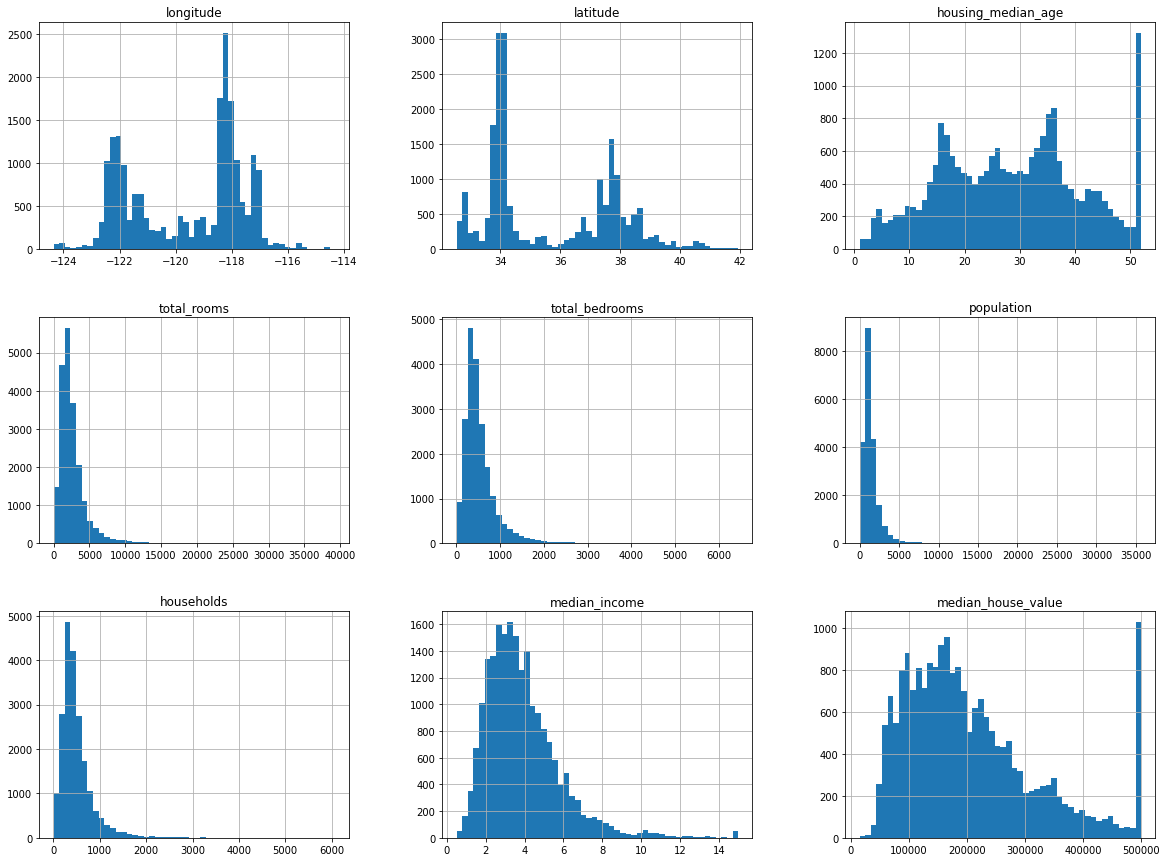

In [ ]:
housing_df.hist(bins=50, figsize=(20, 15))

**Create a test set and neve look at it.**

In [ ]:
def split_train_test(data, test_ratio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32


def split_train_test_by(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[-in_test_set], data.loc[in_test_set]

In [ ]:
np.random.seed(42)
train_set, test_set = split_train_test(housing_df, 0.2)

print(f"Amount of train dataset: {len(train_set)}")
print(f"Amount of test dataset: {len(test_set)}")

Amount of train dataset: 16512
Amount of test dataset: 4128


In [ ]:
housing_with_id = housing_df.reset_index()
train_set, test_set = split_train_test_by(housing_with_id, 0.2, "index")

In [ ]:
housing_with_id["id"] = housing_df["longitude"] * 1000 + housing_df["latitude"]

train_set, test_set = split_train_test_by(housing_with_id, 0.2, "id")

# Preprocessing

In [ ]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"], 
                                  bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
                                  labels=[1, 2, 3, 4, 5])

In [ ]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


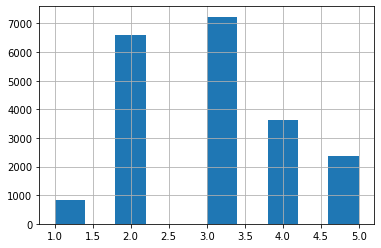

In [ ]:
housing_df["income_cat"].hist()

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)

for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [ ]:
housing = strat_train_set.copy()

**Geographical graphs**

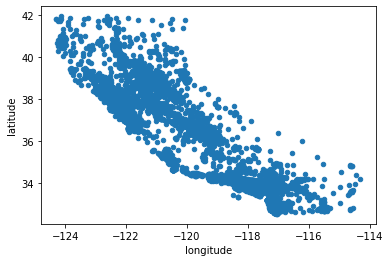

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

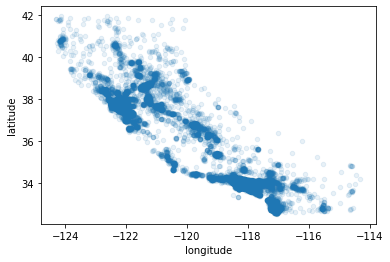

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

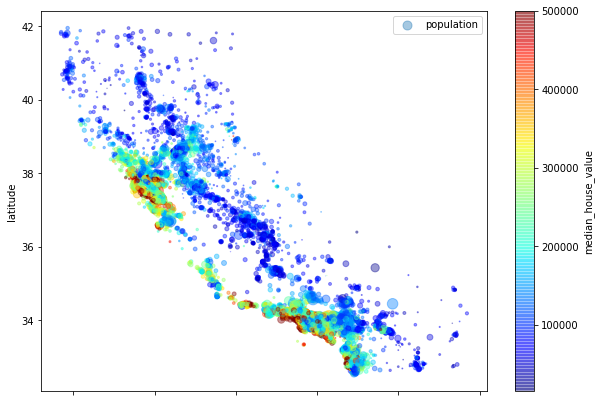

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

**Look for correlations**

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686289
total_rooms           0.135723
housing_median_age    0.109030
households            0.066404
total_bedrooms        0.050819
population           -0.024405
longitude            -0.045513
latitude             -0.145896
Name: median_house_value, dtype: float64

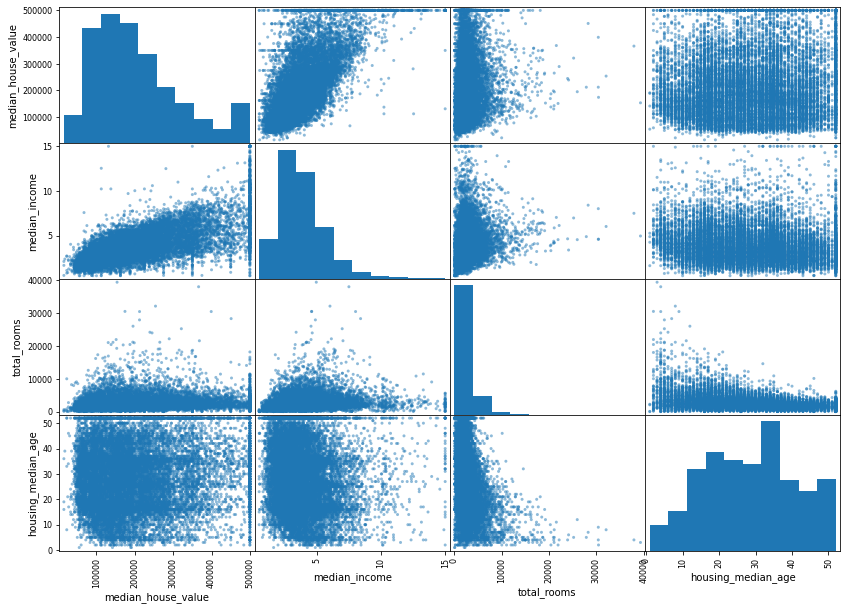

In [ ]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(14, 10))
plt.show()

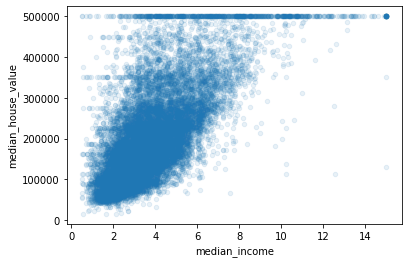

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

**Experiment attribute combinations**

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686289
rooms_per_household         0.147401
total_rooms                 0.135723
housing_median_age          0.109030
households                  0.066404
total_bedrooms              0.050819
population_per_household   -0.021876
population                 -0.024405
longitude                  -0.045513
latitude                   -0.145896
bedrooms_per_room          -0.253819
Name: median_house_value, dtype: float64

## Prepare the data for ML Algorithms

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

**Data Cleaning**

In [ ]:
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3

housing["total_bedrooms"].fillna(median, inplace=True)

In [ ]:
imputer = SimpleImputer(strategy="median")

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [ ]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229


In [ ]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [ ]:
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2125.     ,  435.     ,
       1166.5    ,  409.     ,    3.53715])

In [ ]:
housing_num.median().values

array([-118.5    ,   34.26   ,   29.     , 2125.     ,  435.     ,
       1166.5    ,  409.     ,    3.53715])

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229


## Handling Text and Categorical Attributes

In [ ]:
housing_cat = housing[["ocean_proximity"]]

housing_cat.head()

,ocean_proximity
8088,NEAR OCEAN
15259,NEAR OCEAN
710,NEAR BAY
12828,INLAND
18294,NEAR BAY


In [ ]:
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:5]

array([[4.],
       [4.],
       [3.],
       [1.],
       [3.]])

In [ ]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

In [ ]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if (self.add_bedrooms_per_room):
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_(X, rooms_per_household, population_per_household,
                         bedrooms_per_room)
        return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformation Pipeline

In [ ]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributeAdder(add_bedrooms_per_room=False)),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
8088,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,NEAR OCEAN
15259,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,NEAR OCEAN
710,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,NEAR BAY
12828,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853,INLAND
18294,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229,NEAR BAY


In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

# Selected and Train a Model

### Using Linear Regression Algorithms

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print(f"Predictions: {lin_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictions: [183296.2700776  217303.20434967 189139.40854917 140555.75473093
 387630.11947135]
Labels: [139300.0, 215800.0, 275000.0, 90400.0, 500001.0]


In [ ]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68306.45468762996

## Using Decision Tree Algorithms

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Using K-fold cross validation

In [ ]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scored = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")

In [ ]:
display_scores(tree_rmse_scored)

Scores: [69352.09984611 70504.22012284 73073.41212579 69653.65917091
 67294.05810054 70668.11621999 73739.21274151 73279.82876186
 72866.27653126 72496.71213777]
Mean: 71292.75957585897
Standard Deviation: 2012.067482203733


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67982.21481055 64916.84179865 67663.58158155 69840.29357413
 68861.25183523 66759.29899158 71668.7008457  72227.86817392
 68569.8192162  66272.65462753]
Mean: 68476.25254550632
Standard Deviation: 2183.1541083953402


### Using Random Forest Algorithm

In [ ]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18715.155623759474

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [48668.35179515 47489.68316368 49401.79293201 51372.63033041
 50343.43642976 49729.30521542 53245.57423546 52551.16667803
 51225.41079974 50341.75230704]
Mean: 50436.910388667966
Standard Deviation: 1651.0569479940773


**save the model**

In [ ]:
joblib.dump(forest_reg, "reports/models/forest_regressor.pkl")

['reports/models/forest_regressor.pkl']

**load the model**

In [ ]:
forest_reg = joblib.load("reports/models/forest_regressor.pkl")

### Using Ridge Algorithm

In [ ]:
ridge_reg = Ridge()
ridge_reg.fit(housing_prepared, housing_labels)

Ridge()

In [ ]:
housing_predictions = ridge_reg.predict(housing_prepared)
ridge_mse = mean_squared_error(housing_labels, housing_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse

68307.57146670665

In [ ]:
ridge_scores = cross_val_score(ridge_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

Scores: [67945.64319828 64918.79263188 67663.63526504 69838.28153132
 68868.31729411 66759.20077715 71667.53781342 72225.32151113
 68654.07675667 66272.97738278]
Mean: 68481.37841617699
Standard Deviation: 2183.5777654775234


### Using Support Vector Machine Algorithm

In [ ]:
svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)

SVR()

In [ ]:
housing_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118115.73199642693

In [ ]:
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [118707.39340601 114122.7557943  119037.77783226 118372.58821844
 117762.60652311 123364.03066552 121216.27961538 120809.12094321
 111953.20779874 115811.5006657 ]
Mean: 118115.72614626514
Standard Deviation: 3240.8845768507076


**save the model**

In [ ]:
joblib.dump(svr_reg, "reports/models/svr_regressor.pkl")

['reports/models/svr_regressor.pkl']

**load the model**

In [ ]:
svr_reg = joblib.load("reports/models/svr_regressor.pkl")

### Using Neural Network Algorithm

In [ ]:
mlp_reg = MLPRegressor()
mlp_reg.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor()

In [ ]:
housing_predictions = mlp_reg.predict(housing_prepared)
mlp_mse = mean_squared_error(housing_labels, housing_predictions)
mlp_rmse = np.sqrt(mlp_mse)
mlp_rmse

169641.5894075765

In [ ]:
mlp_scores = cross_val_score(mlp_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
mlp_rmse_scores = np.sqrt(-mlp_scores)
display_scores(mlp_rmse_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

Scores: [175693.78911961 170594.73551275 179131.38274863 181167.97810816
 179960.07296856 181611.09983406 180143.63517222 181361.9739967
 171165.32015364 176110.44326961]
Mean: 177694.0430883933
Standard Deviation: 3919.1811498092047


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## Fine Tunning 

### Grid Search for Random Forest Algorithm

In [ ]:
param_grid = [
    {"n_estimators": [3, 10, 30],
     "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False],
     "n_estimators": [3, 10],
     "max_features": [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search_forest = GridSearchCV(forest_reg, param_grid, cv=5,
                                  scoring="neg_mean_squared_error",
                                  return_train_score=True)

grid_search_forest.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search_forest.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search_forest.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [ ]:
cvres = grid_search_forest.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62636.71655813004 {'max_features': 2, 'n_estimators': 3}
54909.45639673096 {'max_features': 2, 'n_estimators': 10}
52122.56292068315 {'max_features': 2, 'n_estimators': 30}
60031.56738843703 {'max_features': 4, 'n_estimators': 3}
52995.33570270459 {'max_features': 4, 'n_estimators': 10}
50065.9057108277 {'max_features': 4, 'n_estimators': 30}
59783.123801119815 {'max_features': 6, 'n_estimators': 3}
51903.60875690477 {'max_features': 6, 'n_estimators': 10}
49847.43829595041 {'max_features': 6, 'n_estimators': 30}
59155.46453463879 {'max_features': 8, 'n_estimators': 3}
52049.04353053182 {'max_features': 8, 'n_estimators': 10}
50459.50502732662 {'max_features': 8, 'n_estimators': 30}
61834.40996518536 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53748.59331736547 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59523.18418665026 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52459.95922006172 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

### Randomized Search CV Random Forest Algorithm

In [ ]:
from re import S
rf_p_dist={
    'max_depth':[3,5,10,None],
    'n_estimators':[10,100,200,300,400,500],
    'max_features':randint(1,3),
    'bootstrap':[True,False],
    'min_samples_leaf':randint(1,4),
}

nbr_iter = 40

forest_reg = RandomForestRegressor()

rdmsearch = RandomizedSearchCV(forest_reg, param_distributions=rf_p_dist,
                               scoring="neg_mean_squared_error",
                                n_jobs=-1, n_iter=nbr_iter, cv=9)
#CV = Cross-Validation ( here using Stratified KFold CV)
rdmsearch.fit(housing_prepared, housing_labels)

ht_params = rdmsearch.best_params_
ht_score = rdmsearch.best_score_


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
ht_params

{'bootstrap': False,
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [ ]:
np.sqrt(-ht_score)

49739.22012798475

## Analyze the best Model and Their Errors

In [ ]:
feature_importance = grid_search_forest.best_estimator_.feature_importances_
feature_importance

array([8.02603995e-02, 7.57727905e-02, 4.44088073e-02, 2.04749444e-02,
       1.82931683e-02, 1.93099784e-02, 1.74922179e-02, 3.79275814e-01,
       7.57514482e-02, 1.07431653e-01, 8.55477270e-03, 1.44261236e-01,
       1.49616477e-04, 3.98853870e-03, 4.57461328e-03])

In [ ]:
extra_attribs = ["rooms_per_hold", "pop_per_hold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importance, attributes), reverse=True)

[(0.37927581448894976, 'median_income'),
 (0.14426123633990687, '<1H OCEAN'),
 (0.10743165345386146, 'pop_per_hold'),
 (0.0802603994828308, 'longitude'),
 (0.07577279050634, 'latitude'),
 (0.07575144817790859, 'rooms_per_hold'),
 (0.0444088073414255, 'housing_median_age'),
 (0.020474944435279703, 'total_rooms'),
 (0.019309978432909346, 'population'),
 (0.0182931683167641, 'total_bedrooms'),
 (0.01749221787034783, 'households'),
 (0.008554772698997144, 'bedrooms_per_room'),
 (0.004574613280082811, 'NEAR BAY'),
 (0.0039885386976170585, 'ISLAND'),
 (0.00014961647677876532, 'INLAND')]

# Evaluate my Sytem on the Test Set

In [ ]:
final_model = grid_search_forest.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"]

X_test_prepared = full_pipeline.transform(X_test)

In [ ]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45656.35528638, 49925.61706587])